In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Dependencies 
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import pickle

## Preprocess

In [3]:
# Read in files

file_path = 'Data/Cleaned_Data/'

In [4]:
# Read in Health Ranking Data
df = pd.read_csv(f"../../{file_path}Health_Mean_Rank.csv")
print(df.shape)
df.head()

(3142, 5)


,Unnamed: 0,FIPS,State,County,Mean_Rank
0,1,1001,Alabama,Autauga,14.375
1,2,1003,Alabama,Baldwin,10.500
2,3,1005,Alabama,Barbour,41.125
3,4,1007,Alabama,Bibb,32.875
4,5,1009,Alabama,Blount,25.875


In [5]:
# Read in the Merged Data
df2 = pd.read_csv(f"../../{file_path}Merged_Demographic_Data.csv")
print(df2.shape)
df2.head()

(3033, 25)


,County,State,FIPS,Lyme_Disease_Incidence_Reported,Population,%<18_Yrs_Old,%65_Yrs_Old_and_over,Income($),African_American(Count),African_American(%),...,Native_Hawaiian/Other_Pacific_Islander(%),Hispanic(Count),Hispanic(%),Non-Hispanic_White_(Count),Non-Hispanic_White(%),Female(%),Rural(Count),Rural(%),Life_Expectancy,Deaths(Count)
0,Autauga,Alabama,1001,1.0,55504,23.94,15.12,$58343.00,10687,19.25,...,0.10,1586,2.86,41336,74.47,51.34,22921.0,42.00,76.33,815.0
1,Baldwin,Alabama,1003,0.0,212628,21.85,19.95,$56607.00,19037,8.95,...,0.07,9675,4.55,176582,83.05,51.45,77060.0,42.28,78.60,2827.0
2,Barbour,Alabama,1005,1.0,25270,20.76,18.82,$32490.00,12115,47.94,...,0.19,1063,4.21,11613,45.96,47.23,18613.0,67.79,75.78,451.0
3,Bibb,Alabama,1007,0.0,22668,20.61,16.02,$45795.00,4864,21.46,...,0.11,598,2.64,16842,74.30,46.45,15663.0,68.35,73.93,445.0
4,Blount,Alabama,1009,0.0,58013,23.35,17.84,$48253.00,847,1.46,...,0.12,5549,9.57,50439,86.94,50.69,51562.0,89.95,74.60,1050.0


In [6]:
df_merged = df.merge(df2, how='left', on='FIPS')
print(df_merged.shape)
df_merged.head()

(3142, 29)


,Unnamed: 0,FIPS,State_x,County_x,Mean_Rank,County_y,State_y,Lyme_Disease_Incidence_Reported,Population,%<18_Yrs_Old,...,Native_Hawaiian/Other_Pacific_Islander(%),Hispanic(Count),Hispanic(%),Non-Hispanic_White_(Count),Non-Hispanic_White(%),Female(%),Rural(Count),Rural(%),Life_Expectancy,Deaths(Count)
0,1,1001,Alabama,Autauga,14.375,Autauga,Alabama,1.0,55504.0,23.94,...,0.10,1586.0,2.86,41336.0,74.47,51.34,22921.0,42.00,76.33,815.0
1,2,1003,Alabama,Baldwin,10.500,Baldwin,Alabama,0.0,212628.0,21.85,...,0.07,9675.0,4.55,176582.0,83.05,51.45,77060.0,42.28,78.60,2827.0
2,3,1005,Alabama,Barbour,41.125,Barbour,Alabama,1.0,25270.0,20.76,...,0.19,1063.0,4.21,11613.0,45.96,47.23,18613.0,67.79,75.78,451.0
3,4,1007,Alabama,Bibb,32.875,Bibb,Alabama,0.0,22668.0,20.61,...,0.11,598.0,2.64,16842.0,74.30,46.45,15663.0,68.35,73.93,445.0
4,5,1009,Alabama,Blount,25.875,Blount,Alabama,0.0,58013.0,23.35,...,0.12,5549.0,9.57,50439.0,86.94,50.69,51562.0,89.95,74.60,1050.0


In [7]:
df_merged = df_merged.dropna()
df_merged = df_merged.rename(columns={"Mean_Rank": "Average_Health_Rank"})


In [8]:
df_merged['Income($)'] = df_merged['Income($)'].str.replace('$', '')
df_merged['Income($)'] = df_merged['Income($)'].astype('float') / 100

In [9]:
df3 = pd.read_csv(f"../../{file_path}Ticks_Cases_Lat_Long.csv")
df3.head()

,Unnamed: 0,FIPS,County,State,Lat,Long,Ticks_With_Lyme,Cases2019
0,0,1001.0,Autauga County,Alabama,32.5349,-86.6427,0,1
1,1,1003.0,Baldwin County,Alabama,30.7275,-87.7226,0,0
2,2,1005.0,Barbour County,Alabama,31.8696,-85.3932,0,1
3,3,1007.0,Bibb County,Alabama,32.9986,-87.1265,0,0
4,4,1009.0,Blount County,Alabama,33.9809,-86.5674,0,0


In [10]:
mldf = df_merged.merge(df3, on='FIPS')
print(mldf.shape)
mldf.head()

(3013, 36)


,Unnamed: 0_x,FIPS,State_x,County_x,Average_Health_Rank,County_y,State_y,Lyme_Disease_Incidence_Reported,Population,%<18_Yrs_Old,...,Rural(%),Life_Expectancy,Deaths(Count),Unnamed: 0_y,County,State,Lat,Long,Ticks_With_Lyme,Cases2019
0,1,1001,Alabama,Autauga,14.375,Autauga,Alabama,1.0,55504.0,23.94,...,42.00,76.33,815.0,0,Autauga County,Alabama,32.5349,-86.6427,0,1
1,2,1003,Alabama,Baldwin,10.500,Baldwin,Alabama,0.0,212628.0,21.85,...,42.28,78.60,2827.0,1,Baldwin County,Alabama,30.7275,-87.7226,0,0
2,3,1005,Alabama,Barbour,41.125,Barbour,Alabama,1.0,25270.0,20.76,...,67.79,75.78,451.0,2,Barbour County,Alabama,31.8696,-85.3932,0,1
3,4,1007,Alabama,Bibb,32.875,Bibb,Alabama,0.0,22668.0,20.61,...,68.35,73.93,445.0,3,Bibb County,Alabama,32.9986,-87.1265,0,0
4,5,1009,Alabama,Blount,25.875,Blount,Alabama,0.0,58013.0,23.35,...,89.95,74.60,1050.0,4,Blount County,Alabama,33.9809,-86.5674,0,0


In [11]:
# Check for null values
for col in mldf:
    print(f'{col} has {mldf[col].isnull().sum()} nulls')

Unnamed: 0_x has 0 nulls
FIPS has 0 nulls
State_x has 0 nulls
County_x has 0 nulls
Average_Health_Rank has 0 nulls
County_y has 0 nulls
State_y has 0 nulls
Lyme_Disease_Incidence_Reported has 0 nulls
Population has 0 nulls
%<18_Yrs_Old has 0 nulls
%65_Yrs_Old_and_over has 0 nulls
Income($) has 0 nulls
African_American(Count) has 0 nulls
African_American(%) has 0 nulls
American_Indian/Alaskan_Native(Count) has 0 nulls
American_Indian/Alaskan_Native(%) has 0 nulls
Asian(Count) has 0 nulls
Asian(%) has 0 nulls
Native_Hawaiian/Other_Pacific_Islander(Count) has 0 nulls
Native_Hawaiian/Other_Pacific_Islander(%) has 0 nulls
Hispanic(Count) has 0 nulls
Hispanic(%) has 0 nulls
Non-Hispanic_White_(Count) has 0 nulls
Non-Hispanic_White(%) has 0 nulls
Female(%) has 0 nulls
Rural(Count) has 0 nulls
Rural(%) has 0 nulls
Life_Expectancy has 0 nulls
Deaths(Count) has 0 nulls
Unnamed: 0_y has 0 nulls
County has 0 nulls
State has 0 nulls
Lat has 0 nulls
Long has 0 nulls
Ticks_With_Lyme has 0 nulls
Cases

In [12]:
mldf.dtypes

Unnamed: 0_x                                       int64
FIPS                                               int64
State_x                                           object
County_x                                          object
Average_Health_Rank                              float64
County_y                                          object
State_y                                           object
Lyme_Disease_Incidence_Reported                  float64
Population                                       float64
%<18_Yrs_Old                                     float64
%65_Yrs_Old_and_over                             float64
Income($)                                        float64
African_American(Count)                          float64
African_American(%)                              float64
American_Indian/Alaskan_Native(Count)            float64
American_Indian/Alaskan_Native(%)                float64
Asian(Count)                                     float64
Asian(%)                       

In [13]:
# Lyme disease incident reported bin key
ldir_key_df = pd.DataFrame({
    "bin_sizes": ['0 Lyme Incidence Reported per 10000', 
                'Average Lyme Incidence Reported per 10000',
                'Above Lyme Average Incidence Reported per 10000', 
                'Highest Lyme Incidence Reported per 10000'],
    "bin_ids": [0,1,2,3]
})
ldir_key_df.head()


,bin_sizes,bin_ids
0,0 Lyme Incidence Reported per 10000,0
1,Average Lyme Incidence Reported per 10000,1
2,Above Lyme Average Incidence Reported per 10000,2
3,Highest Lyme Incidence Reported per 10000,3


In [14]:
# Scale the Incidence of Lyme Disease for the Population 
mldf['Norm_Incidence'] = mldf['Lyme_Disease_Incidence_Reported']/mldf['Population']*100000

In [15]:
mldf['Norm_Incidence'].describe()

count    3013.000000
mean       13.094353
std        41.545650
min         0.000000
25%         0.000000
50%         0.000000
75%         3.513950
max       583.061071
Name: Norm_Incidence, dtype: float64

In [16]:
# Create a map function to bin the incidence of lyme reported
def map_fxn (x):
    if x ==0:
        return 0
    elif x <= 13.0944:
        return 1
    elif x <= 41.5456 + 13.0944:
        return 2
    else:
        return 3


In [17]:
# Map value to mldf to match the key df
mldf['Norm_Incidence_Bin']= mldf['Norm_Incidence'].map(map_fxn)
mldf.head()

,Unnamed: 0_x,FIPS,State_x,County_x,Average_Health_Rank,County_y,State_y,Lyme_Disease_Incidence_Reported,Population,%<18_Yrs_Old,...,Deaths(Count),Unnamed: 0_y,County,State,Lat,Long,Ticks_With_Lyme,Cases2019,Norm_Incidence,Norm_Incidence_Bin
0,1,1001,Alabama,Autauga,14.375,Autauga,Alabama,1.0,55504.0,23.94,...,815.0,0,Autauga County,Alabama,32.5349,-86.6427,0,1,1.801672,1
1,2,1003,Alabama,Baldwin,10.500,Baldwin,Alabama,0.0,212628.0,21.85,...,2827.0,1,Baldwin County,Alabama,30.7275,-87.7226,0,0,0.000000,0
2,3,1005,Alabama,Barbour,41.125,Barbour,Alabama,1.0,25270.0,20.76,...,451.0,2,Barbour County,Alabama,31.8696,-85.3932,0,1,3.957262,1
3,4,1007,Alabama,Bibb,32.875,Bibb,Alabama,0.0,22668.0,20.61,...,445.0,3,Bibb County,Alabama,32.9986,-87.1265,0,0,0.000000,0
4,5,1009,Alabama,Blount,25.875,Blount,Alabama,0.0,58013.0,23.35,...,1050.0,4,Blount County,Alabama,33.9809,-86.5674,0,0,0.000000,0


In [18]:
mldf = mldf.drop(['Unnamed: 0_x','Unnamed: 0_y','County_y','State_y','State_x','County_x','African_American(Count)','American_Indian/Alaskan_Native(Count)',
           'Hispanic(Count)','Non-Hispanic_White_(Count)','Asian(Count)',
           'Native_Hawaiian/Other_Pacific_Islander(Count)','Rural(Count)','Lyme_Disease_Incidence_Reported','County_x','State_x','Cases2019'], axis=1)

In [19]:
list(mldf.columns)

['FIPS',
 'Average_Health_Rank',
 'Population',
 '%<18_Yrs_Old',
 '%65_Yrs_Old_and_over',
 'Income($)',
 'African_American(%)',
 'American_Indian/Alaskan_Native(%)',
 'Asian(%)',
 'Native_Hawaiian/Other_Pacific_Islander(%)',
 'Hispanic(%)',
 'Non-Hispanic_White(%)',
 'Female(%)',
 'Rural(%)',
 'Life_Expectancy',
 'Deaths(Count)',
 'County',
 'State',
 'Lat',
 'Long',
 'Ticks_With_Lyme',
 'Norm_Incidence',
 'Norm_Incidence_Bin']

In [20]:
mldf.head()

,FIPS,Average_Health_Rank,Population,%<18_Yrs_Old,%65_Yrs_Old_and_over,Income($),African_American(%),American_Indian/Alaskan_Native(%),Asian(%),Native_Hawaiian/Other_Pacific_Islander(%),...,Rural(%),Life_Expectancy,Deaths(Count),County,State,Lat,Long,Ticks_With_Lyme,Norm_Incidence,Norm_Incidence_Bin
0,1001,14.375,55504.0,23.94,15.12,583.43,19.25,0.48,1.28,0.10,...,42.00,76.33,815.0,Autauga County,Alabama,32.5349,-86.6427,0,1.801672,1
1,1003,10.500,212628.0,21.85,19.95,566.07,8.95,0.78,1.16,0.07,...,42.28,78.60,2827.0,Baldwin County,Alabama,30.7275,-87.7226,0,0.000000,0
2,1005,41.125,25270.0,20.76,18.82,324.90,47.94,0.65,0.46,0.19,...,67.79,75.78,451.0,Barbour County,Alabama,31.8696,-85.3932,0,3.957262,1
3,1007,32.875,22668.0,20.61,16.02,457.95,21.46,0.43,0.22,0.11,...,68.35,73.93,445.0,Bibb County,Alabama,32.9986,-87.1265,0,0.000000,0
4,1009,25.875,58013.0,23.35,17.84,482.53,1.46,0.63,0.30,0.12,...,89.95,74.60,1050.0,Blount County,Alabama,33.9809,-86.5674,0,0.000000,0


In [21]:
# Export Merged DF as csv
mldf.to_csv(f"../../{file_path}/ML_Demographic_LymeCase_HealthRank.csv", index=False)

# Linear Regression Model

(3013, 1)
(3013,)


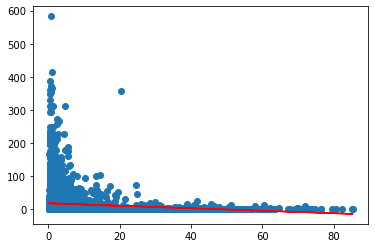

(3013, 1)
(3013,)


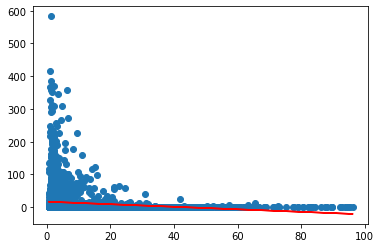

(3013, 1)
(3013,)


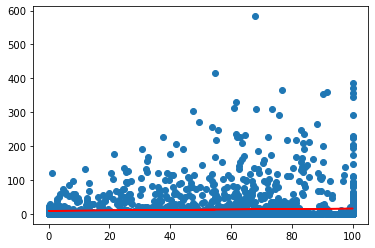

(<matplotlib.collections.PathCollection at 0x2674be6b6c8>,
 None)

In [22]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Create a function to take in multiple columns and run a linear regression
def linear_reg(indp, dep):
    X = mldf[indp].array.reshape(-1, 1)

    print(X.shape)
    y = mldf[dep]

    model = LinearRegression()

    model.fit(X, y)
    y_pred = model.predict(X)
    print(y_pred.shape)

    return plt.scatter(X, y), plt.plot(X, y_pred, color='red'), plt.show()


# Call the function with different indipendent variables
linear_reg('African_American(%)', 'Norm_Incidence')
linear_reg('Hispanic(%)', 'Norm_Incidence')
linear_reg('Rural(%)', 'Norm_Incidence')


## Split the Data into Training and Testing

In [23]:
# Create our features
X =pd.get_dummies(mldf.drop(axis=1, columns=['Norm_Incidence_Bin','State','County','FIPS','Norm_Incidence']))
# Create our target
y = mldf['Norm_Incidence_Bin']
y.value_counts()

0    1878
1     665
2     242
3     228
Name: Norm_Incidence_Bin, dtype: int64

In [24]:
X.describe()

,Average_Health_Rank,Population,%<18_Yrs_Old,%65_Yrs_Old_and_over,Income($),African_American(%),American_Indian/Alaskan_Native(%),Asian(%),Native_Hawaiian/Other_Pacific_Islander(%),Hispanic(%),Non-Hispanic_White(%),Female(%),Rural(%),Life_Expectancy,Deaths(Count),Lat,Long,Ticks_With_Lyme
count,3013.000000,3.013000e+03,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000,3013.000000
mean,47.429057,1.068290e+05,22.281802,18.745456,510.840853,8.929549,2.226057,1.507315,0.121749,9.429346,76.536893,49.907839,58.239300,77.445058,1225.150680,38.366096,-91.954839,0.137073
std,35.794107,3.393090e+05,3.380324,4.509754,134.428373,14.162821,7.317716,2.832966,0.430724,13.777920,19.928270,2.201147,30.700675,2.912101,3207.772879,5.190837,12.395843,0.343981
min,1.000000,1.718000e+03,7.160000,4.770000,226.790000,0.080000,0.050000,0.000000,0.000000,0.520000,2.760000,26.570000,0.000000,62.590000,20.000000,19.598700,-164.027200,0.000000
25%,22.125000,1.197600e+04,20.260000,15.850000,422.740000,0.710000,0.370000,0.450000,0.030000,2.280000,64.870000,49.460000,33.710000,75.510000,189.000000,34.640500,-97.724600,0.000000
50%,39.375000,2.694700e+04,22.240000,18.410000,489.240000,2.240000,0.620000,0.710000,0.060000,4.210000,83.850000,50.320000,58.910000,77.540000,417.000000,38.359600,-90.113800,0.000000
75%,60.875000,6.971300e+04,24.000000,21.180000,568.380000,10.170000,1.290000,1.380000,0.110000,9.650000,92.540000,51.000000,83.870000,79.270000,1001.000000,41.724200,-83.493200,0.000000
max,220.125000,1.016351e+07,41.240000,56.940000,1361.910000,85.330000,87.980000,43.010000,13.120000,96.320000,97.920000,57.000000,100.000000,97.970000,83305.000000,69.312200,-67.628800,1.000000


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=1, stratify=y)
X_train.shape

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier.

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

## Random Forest

In [26]:
# Different model:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Create a random forest classifier model
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fit the model 
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

## Pickle the model

In [27]:
# saves a Python object to a pickled file using a relative path from the ../data/ directory.
pickle.dump(brf, open('../pickle_data/brfmodel.pkl', 'wb'))

In [28]:
# Load the model as an object
pickled_model = pickle.load(open('../pickle_data/brfmodel.pkl', 'rb'))

# Make predictions using the testing data
predictions = pickled_model.predict(X_test)

In [29]:
# Calculated the balanced accuracy score
acc_score = balanced_accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.6331630546327877


In [30]:
matrix = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(matrix, columns=['Predicted 0 Cases (per 100000 Reported)','Predicted Avergae Cases (per 100000 Reported)',
                                      'Predicted Above Average Cases (per 100000 Reported)', 'Predicted Highest Risk (per 10000 Reported)'],
                     index=['Actual 0 Cases (per 100000 Reported)', 'Actual Avergae Cases (per 100000 Reported)',
                            'Actual Above Average Cases (per 100000 Reported)', 'Actual Highest Risk (per 100000 Reported)'])
cm_df


,Predicted 0 Cases (per 100000 Reported),Predicted Avergae Cases (per 100000 Reported),Predicted Above Average Cases (per 100000 Reported),Predicted Highest Risk (per 10000 Reported)
Actual 0 Cases (per 100000 Reported),439,77,42,5
Actual Avergae Cases (per 100000 Reported),31,120,38,11
Actual Above Average Cases (per 100000 Reported),12,6,38,17
Actual Highest Risk (per 100000 Reported),4,0,21,43


In [31]:
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.78      0.86      0.84      0.82      0.67       563
          1       0.59      0.60      0.88      0.60      0.73      0.51       200
          2       0.27      0.52      0.88      0.36      0.68      0.44        73
          3       0.57      0.63      0.96      0.60      0.78      0.59        68

avg / total       0.76      0.71      0.88      0.73      0.78      0.61       904



In [32]:
# List the features sorted in descending order by feature importance
sorted(zip(brf.feature_importances_, X.columns), reverse= True)

[(0.14116340769550884, 'Long'),
 (0.10273861237351856, 'Lat'),
 (0.06585472570877564, 'Population'),
 (0.057912106361775385, 'Non-Hispanic_White(%)'),
 (0.05689729873188229, '%<18_Yrs_Old'),
 (0.055514940908615015, 'Deaths(Count)'),
 (0.051023224099588586, 'African_American(%)'),
 (0.0493561784155862, 'Life_Expectancy'),
 (0.049056521408606175, 'Hispanic(%)'),
 (0.04542967718497549, 'Average_Health_Rank'),
 (0.04498594383184237, 'American_Indian/Alaskan_Native(%)'),
 (0.04437667210739831, '%65_Yrs_Old_and_over'),
 (0.042247803380310076, 'Asian(%)'),
 (0.0422152719637934, 'Rural(%)'),
 (0.04204436944426218, 'Income($)'),
 (0.041507882181120496, 'Female(%)'),
 (0.03526002858512011, 'Native_Hawaiian/Other_Pacific_Islander(%)'),
 (0.03241533561732088, 'Ticks_With_Lyme')]

## Easy Ensemble

In [33]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec.fit(X_train, y_train) 

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [34]:
# saves a Python object to a pickled file using a relative path from the ../data/ directory.
pickle.dump(eec, open('../pickle_data/easyensemble.pkl', 'wb'))

In [35]:
# Load the model as an object
pickled_model = pickle.load(open('../pickle_data/easyensemble.pkl', 'rb'))

# Make predictions using the testing data
predictions = pickled_model.predict(X_test)

In [36]:
# Calculated the balanced accuracy score
acc_score2 = balanced_accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score2}")

Accuracy Score : 0.588866361783527


In [37]:
matrix = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(matrix, columns=['Predicted 0 Cases (per 100000 Reported)', 'Predicted Avergae Cases (per 100000 Reported)',
                                      'Predicted Above Average Cases (per 100000 Reported)', 'Predicted Highest Risk (per 10000 Reported)'],
                     index=['Actual 0 Cases (per 100000 Reported)', 'Actual Avergae Cases (per 100000 Reported)',
                            'Actual Above Average Cases (per 100000 Reported)', 'Actual Highest Risk (per 100000 Reported)'])
cm_df


,Predicted 0 Cases (per 100000 Reported),Predicted Avergae Cases (per 100000 Reported),Predicted Above Average Cases (per 100000 Reported),Predicted Highest Risk (per 10000 Reported)
Actual 0 Cases (per 100000 Reported),417,87,56,3
Actual Avergae Cases (per 100000 Reported),54,101,37,8
Actual Above Average Cases (per 100000 Reported),10,8,37,18
Actual Highest Risk (per 100000 Reported),1,0,26,41


In [38]:
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.74      0.81      0.80      0.77      0.60       563
          1       0.52      0.51      0.87      0.51      0.66      0.42       200
          2       0.24      0.51      0.86      0.32      0.66      0.42        73
          3       0.59      0.60      0.97      0.59      0.76      0.56        68

avg / total       0.72      0.66      0.84      0.68      0.74      0.54       904



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the `SMOTE` algorithm. 

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [39]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 1315, 1: 1315, 3: 1315, 2: 1315})

In [40]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

## Pickle the model

In [41]:
# saves a Python object to a pickled file using a relative path from the ../data/ directory.
pickle.dump(classifier, open('../pickle_data/naiveoversample.pkl', 'wb'))

In [42]:
# Load the model as an object
pickled_model = pickle.load(open('../pickle_data/naiveoversample.pkl', 'rb'))

# Make predictions using the testing data
predictions = pickled_model.predict(X_test)

In [43]:
# Calculated the balanced accuracy score
print(balanced_accuracy_score(y_test, predictions))

0.5945749252522246


In [44]:
matrix = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(matrix, columns=['Predicted 0 Cases (per 100000 Reported)', 'Predicted Avergae Cases (per 100000 Reported)',
                                      'Predicted Above Average Cases (per 100000 Reported)', 'Predicted Highest Risk (per 10000 Reported)'],
                     index=['Actual 0 Cases (per 100000 Reported)', 'Actual Avergae Cases (per 100000 Reported)',
                            'Actual Above Average Cases (per 100000 Reported)', 'Actual Highest Risk (per 100000 Reported)'])
cm_df


,Predicted 0 Cases (per 100000 Reported),Predicted Avergae Cases (per 100000 Reported),Predicted Above Average Cases (per 100000 Reported),Predicted Highest Risk (per 10000 Reported)
Actual 0 Cases (per 100000 Reported),441,73,40,9
Actual Avergae Cases (per 100000 Reported),38,108,41,13
Actual Above Average Cases (per 100000 Reported),12,7,33,21
Actual Highest Risk (per 100000 Reported),2,0,25,41


In [45]:
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.78      0.85      0.84      0.81      0.66       563
          1       0.57      0.54      0.89      0.56      0.69      0.46       200
          2       0.24      0.45      0.87      0.31      0.63      0.38        73
          3       0.49      0.60      0.95      0.54      0.76      0.55        68

avg / total       0.74      0.69      0.87      0.71      0.77      0.59       904



### SMOTE Oversampling

In [46]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)
Counter(y_resampled)

Counter({0: 1315, 1: 1315, 3: 1315, 2: 1315})

In [47]:
# Train the Logistic Regression model using the resampled data
classifier2 = LogisticRegression(random_state=1)
classifier2.fit(X_resampled, y_resampled)
# Create a random forest classifier model
# brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# # Fit the model 
# brf.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

## Pickle the model

In [48]:
# saves a Python object to a pickled file using a relative path from the ../data/ directory.
pickle.dump(classifier2, open('../pickle_data/smotemodel.pkl', 'wb'))

In [49]:
# Load the model as an object
pickled_model = pickle.load(open('../pickle_data/smotemodel.pkl', 'rb'))

# Make predictions using the testing data
predictions = pickled_model.predict(X_test)

In [50]:
# Calculated the balanced accuracy score
print(balanced_accuracy_score(y_test, predictions))

0.5926795735691294


In [51]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(matrix, columns=['Predicted 0 Cases (per 100000 Reported)','Predicted Avergae Cases (per 100000 Reported)',
                                      'Predicted Above Average Cases (per 100000 Reported)', 'Predicted Highest Risk (per 10000 Reported)'],
                     index=['Actual 0 Cases (per 100000 Reported)', 'Actual Avergae Cases (per 100000 Reported)',
                            'Actual Above Average Cases (per 100000 Reported)', 'Actual Highest Risk (per 100000 Reported)'])
cm_df


,Predicted 0 Cases (per 100000 Reported),Predicted Avergae Cases (per 100000 Reported),Predicted Above Average Cases (per 100000 Reported),Predicted Highest Risk (per 10000 Reported)
Actual 0 Cases (per 100000 Reported),439,78,37,9
Actual Avergae Cases (per 100000 Reported),38,108,41,13
Actual Above Average Cases (per 100000 Reported),11,8,37,17
Actual Highest Risk (per 100000 Reported),1,0,30,37


In [52]:
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.78      0.85      0.83      0.82      0.66       563
          1       0.56      0.54      0.88      0.55      0.69      0.46       200
          2       0.26      0.51      0.87      0.34      0.66      0.42        73
          3       0.49      0.54      0.95      0.51      0.72      0.50        68

avg / total       0.74      0.69      0.87      0.71      0.77      0.58       904



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. 

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [53]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 160, 1: 160, 2: 160, 3: 160})

In [54]:
# Create Logistic Regression model
classifier3 = LogisticRegression(random_state=1)
classifier3.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [55]:
# saves a Python object to a pickled file using a relative path from the ../data/ directory.
pickle.dump(classifier3, open('../pickle_data/undersample.pkl', 'wb'))

In [56]:
# Load the model as an object
pickled_model = pickle.load(open('../pickle_data/undersample.pkl', 'rb'))

# Make predictions using the testing data
predictions = pickled_model.predict(X_test)

In [57]:
# Calculated the balanced accuracy score
print(balanced_accuracy_score(y_test, predictions))

0.5758549746451538


In [58]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(matrix, columns=['Predicted 0 Cases (per 100000 Reported)','Predicted Avergae Cases (per 100000 Reported)',
                                      'Predicted Above Average Cases (per 100000 Reported)', 'Predicted Highest Risk (per 100000 Reported)'],
                     index=['Actual 0 Cases (per 100000 Reported)', 'Actual Avergae Cases (per 100000 Reported)',
                            'Actual Above Average Cases (per 100000 Reported)', 'Actual Highest Risk (per 100000 Reported)'])
cm_df


,Predicted 0 Cases (per 100000 Reported),Predicted Avergae Cases (per 100000 Reported),Predicted Above Average Cases (per 100000 Reported),Predicted Highest Risk (per 100000 Reported)
Actual 0 Cases (per 100000 Reported),415,95,44,9
Actual Avergae Cases (per 100000 Reported),41,105,42,12
Actual Above Average Cases (per 100000 Reported),10,10,32,21
Actual Highest Risk (per 100000 Reported),2,0,25,41


In [59]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.74      0.84      0.81      0.79      0.62       563
          1       0.50      0.53      0.85      0.51      0.67      0.43       200
          2       0.22      0.44      0.87      0.30      0.62      0.36        73
          3       0.49      0.60      0.95      0.54      0.76      0.55        68

avg / total       0.72      0.66      0.86      0.68      0.75      0.55       904



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. 

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [60]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({0: 391, 1: 590, 2: 711, 3: 833})

In [61]:
# Create a random forest classifier model
brf2 = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fit the model 
brf2.fit(X_resampled, y_resampled)

BalancedRandomForestClassifier(random_state=1)

In [62]:
# saves a Python object to a pickled file using a relative path from the ../data/ directory.
pickle.dump(brf2, open('../pickle_data/SMOTEENN.pkl', 'wb'))

In [63]:
# Load the model as an object
pickled_model = pickle.load(open('../pickle_data/SMOTEENN.pkl', 'rb'))

# Make predictions using the testing data
predictions = pickled_model.predict(X_test)

In [64]:
# X_test.to_dict('records')[0]

In [65]:
# # Export Merged DF as csv
# X_test.to_csv(f"../../{file_path}/pickle_tests.csv", index=False)

In [66]:
# Calculated the balanced accuracy score
print(balanced_accuracy_score(y_test, predictions))

0.25


In [67]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(matrix, columns=['Predicted 0 Cases (per 100000 Reported)', 'Predicted Avergae Cases (per 100000 Reported)',
                                      'Predicted Above Average Cases (per 100000 Reported)', 'Predicted Highest Risk (per 100000 Reported)'],
                     index=['Actual 0 Cases (per 100000 Reported)', 'Actual Avergae Cases (per 100000 Reported)',
                            'Actual Above Average Cases (per 100000 Reported)', 'Actual Highest Risk (per 100000 Reported)'])
cm_df


,Predicted 0 Cases (per 100000 Reported),Predicted Avergae Cases (per 100000 Reported),Predicted Above Average Cases (per 100000 Reported),Predicted Highest Risk (per 100000 Reported)
Actual 0 Cases (per 100000 Reported),563,0,0,0
Actual Avergae Cases (per 100000 Reported),200,0,0,0
Actual Above Average Cases (per 100000 Reported),73,0,0,0
Actual Highest Risk (per 100000 Reported),68,0,0,0


In [68]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.62      1.00      0.00      0.77      0.00      0.00       563
          1       0.00      0.00      1.00      0.00      0.00      0.00       200
          2       0.00      0.00      1.00      0.00      0.00      0.00        73
          3       0.00      0.00      1.00      0.00      0.00      0.00        68

avg / total       0.39      0.62      0.38      0.48      0.00      0.00       904

